<a href="https://colab.research.google.com/github/seungtaemoon/Portfolio/blob/master/Sentiment%20Analysis%20with%20BERT/BERT%EB%A5%BC_%ED%99%9C%EC%9A%A9%ED%95%9C_%EC%98%81%ED%99%94_%EB%A6%AC%EB%B7%B0_%EA%B0%90%EC%A0%95_%EB%B6%84%EC%84%9D(Sentiment_Analysis).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERT를 활용한 영화 리뷰 감정 분석(Sentiment Analysis)

In [ ]:
# 파이썬 버전 확인
!python --version

Python 3.6.9


# 0. 필요한 패키지 설치 

## Google Colab일 때만 실행



In [1]:
!pip install wordcloud
!pip install transformers

     |████████████████████████████████| 1.5MB 23.2MB/s 
     |████████████████████████████████| 2.9MB 45.0MB/s 
     |████████████████████████████████| 890kB 51.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=255a83ab9917561b2c6ff791a30d8249ad60f591849b2ccaec323a1877b9fdc8
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


## Jupyter Notebook일 때만 실행

In [ ]:
# 개별적으로 설치해 주어야할 패키지
conda install -c intel mkl_fft==1.0.15
conda install -c intel mkl_random==1.1
conda install -c intel mkl-service==2.3.0
pip install tbb4py

# Requirements.txt에 있는 모든 패키지 설치
pip install -r requirements_jupyter.txt

# transformers 모듈에 문제가 있을 경우 실행
# conda install -c huggingface transformers

#1. 배경
## 1.1 데이터 선정 이유

자연어처리(Natural Language Processing)은 데이터 과학 분야에서 각광받는 영역 중에 하나다. 텍스트 정보를 이용하여 감정 분석(sentiment analysis)등에 이용할 수 있다. 이 세상에 존재하는 데이터들중 텍스트 데이터의 비중이 매우 크기 때문에, 자연어처리가 활용될 수 있는 분야가 매우 무궁무진하다. 평소 영상보다 음악을 듣는 것보다도 책읽는 것을 좋아하는 나는, 이미지나 동영상 데이터나 텍스트 데이터애 대한 애착이 크다. 

우리나라에서는 대표적으로 동영상 OTT서비스인 왓챠(Watcha)같은 곳이 대표적으로 감정 분석을 활용하는 회사라 할 수 있다. 왓차는 사용자의 기호에따라, 사용자가 즐겨 찾는 타입의 영화 중 가장 인기있는 영화를 추천하는 서비스를 제공하는데, 바로 이런 목적으로 위해 자연어처리 감정분석 기법을 활용할 수 있다. 또한, 사람들이 좋아하는 영화들이 가진 키워드등의 정보를 찾아내, 좀더 최적화된 서비스를 제공하는데 활용하기도 한다. 

이 프로젝트에서는 네이버 데이터를 활용하여, 영화에 대한 유저들의 감정을 분석한다. 왓챠의 영화리뷰 데이터를 직접 얻을 수 있다면 좋았겠으나, 그렇게 할 수 없어 네이버 영화 리뷰 데이터를 왓챠의 내부 유저 콘텐츠 리뷰 데이터로 간주하고 진행하였다. 왓챠의 어떤 영화들이 평이 가장 좋은지, 그 영화들의 공통점이 무엇인지 찾아본다. 감정 분석을 위해, 자연어처리의 가장 최신 기술인 Transformer타입의 BERT 모델을 사용하여 모델링하였으며, 사용한 데이터의 링크는 다음과 같다. [네이버 영화리뷰 데이터](https://github.com/e9t/nsmc/)

나는 아래와 같은 시나리오를 가정했다.

*왓챠의 마케팅 팀장은 자사의 서비스를 개선하고 고객에게 보다 최적화시키기 위해, 고객에게 시청한 영화에 대한 리뷰를 권장하도록 했다. 하지만, 응답률이 매우 저조했다. 팀장은 유인책으로 리뷰를 적으면 영화 한 개를 무료로 볼 수 있도록 유도했다. 고객들은 적극적으로 응답하기 시작했고, 상당한 양의 리뷰 데이터가 쌓였다. 하지만, 마케팅 팀장은 이 것을 어떻게 활용해야할지 고민에 빠졌다. 각 유저들이 자신이 시청한 콘텐츠에 대해 세부적인 리뷰를 적고, 추천할지 안할지를 나타내는 란에 응답을 했지만, 이 정보로 어떻게 개선을 해야할지 방향이 잡히지 않았다.*

*나는 데이터 사이언티스트로써, 이 리뷰들을 상세하게 분석하여, 고객이 전반적으로 왓챠의 컨텐츠에 대해 긍정적으로 생각하는지를 알아보자고 제안했다. 귀가 솔깃했던 그는 어떻게 그것을 할 수 있는지 물었고, 나는 그에게 자연어처리를 바탕으로한 감정분석(Sentiment Analysis)를 할 것을 제안했다. 긍정적인 감정이 표현되었을 경우, 그것을 좀 더 자극할 수 있는 콘텐츠를 모아서 추천하는데 활용할 수 있으며, 부정적인 감정이 표현되었을 경우, 그 감정을 유발할만한 콘텐츠에 대해서는 판권 계약 우선순위에서 뒤로 미룰 수 있다는 식으로 그를 설득했다. 즉, 고객이 느끼는 감정에 따라 콘텐츠를 관리하고, 왓챠 서비스의 방향을 정할 수 있다고 말했다. 그는 흔쾌히 수락하며, 내게 데이터를 건네주었다. 나는 왓차의 유저들이 남긴 전체 리뷰를 분석하여, 유저들이 전반적으로 왓챠의 컨텐츠를 시청하면서 가장 많이 경험했던 감정을 알아내고, 유저들이 전반적으로 왓챠의 컨텐츠에 만족하는지 알아내기 위해 딥러닝을 이용한 분석에 착수했다.*

## 1.2 프로젝트를 통해 답할 질문 및 실험할 가설

위 상황을 가정하면서 나는 2가지의 질문을 만들어 볼 수 있다고 느꼈다.

질문: 유저들이 전반적으로 왓챠 컨텐츠에서 느낀 감정 중 가장 컸던 것은 무엇인가?
* 유저들이 남긴 리뷰에서 감정이 드러나는 키워드를 바탕으로, 어떠한 감정이 가장 많이 나타났는지를 찾아내고, 그 것을 바탕으로 유저들이 전반적으로 왓챠의 컨텐츠에 대해 긍정적으로 생각하는지를 알 수 있다.
또한, 가장 많이 나타난 키워드를 통해, 가장 자주 일어난 감정을 알아내서, 이러한 감정을 일으킬 수 있는 콘텐츠를 정리해 추천하는데 활용할 수 있다. 예를 들어, “웃음"의 감정이 가장 많이 나타나면, “당신을 웃게할 코미디 영화 10선" 등의 추천을 할 수 있고, “슬픔"의 감정이 잦게 드러났다면, “감동과 메시지가 있는 영화들"과 같은 추천을 하는데 활용할 수도 있을 것이다.


가설: 전반적으로 왓챠의 콘텐츠에 만족하는 유저들의 비율과 그렇지 않은 유저들의 비율이 같다.
* 각 리뷰 마다 시청한 컨텐츠가 유저에게 만족스러운지 아닌지에 대한 정보를 가지고 있다. 전체 리뷰에서 "1"의 수가 많을 수록, 왓챠 컨텐츠에 대한 만족도가 높다고 볼 수 있으며, "0"이 많을 수록 불만족스럽다는 것을 예측할 수 있다. 이 문제에서는 만족하는 유저의 비율과 만족하지 못하는 유저의 비율이 균등할 것으로 가정한다. 



##목차:

###1. 배경
> 1.1 데이터 선정 이유

> 1.2 가설

###2. 전처리 및 분석
> 2.1 EDA

> 2.2 토큰화 및 Stopwords제거

> 2.3 키워드 분석하기

###3. 모델

> 3.1 모델링을 위한 준비

> 3.2 모델 fine-tuning

> 3.3 모델 학습

###4. 결론

> 4.1 해석

> 4.2 마치며

> 4.3 참조


# 2. 전처리

먼저 이 프로젝트에 사용할 데이터를 불러온다. 데이터는 이전에 언급한 네이버 영화 리뷰 데이터를 사용한다. 훈련을 위한 데이터와 테스트를 위한 데이터를 따로 가져간다. 데이터는 사용자의 id, 유저들의 영화리뷰 내용을 담은 document, 마지막으로 해당 영화에 만족하는지(1) 또는 불만족하는지(0)를 나타내는 타깃 특성인 label로 이루어져있다. 

[네이버 영화 리뷰 데이터](https://github.com/e9t/nsmc/)

In [2]:
# 필요한 라이브러리 불러오기
import pandas as pd
import urllib.request

In [3]:
# 영화 리뷰 정보 다운로드하기
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7f2d3ff432b0>)

In [4]:
# Pandas로 데이터 불러오기
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [5]:
# 데이터 사이즈 확인
train_data.shape, test_data.shape

((150000, 3), (50000, 3))

In [6]:
# 데이터 확인
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [7]:
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


##2.1 EDA

데이터를 최대한 분석하는 것이 분석 성공의 열쇠이기 때문에, 가장 먼저 기본적으로 해볼 수 있는 EDA를 모두 해본다.

In [8]:
#1. 데이터의 결측치 확인
train_data.isnull().sum()

id          0
document    5
label       0
dtype: int64

In [9]:
test_data.isnull().sum()

id          0
document    3
label       0
dtype: int64

데이터의 결측치가 document 부분에서 존재하기는 하지만, 타깃 레이블인 label 칼럼에는 존재하지 않는다. 아무래도 리뷰를 입력하기 귀찮아 만족 여부만 답한 사람도 있을 것이다. 영화에 대해 세부적인 리뷰가 없는 것에 대해서는 아쉽지만, 그럼에도 불구하고 만족도에 대한 정보는 타깃에 있으므로 일단 결측치는 제거하지 않는다.

In [10]:
# 타깃의 클래스 수 확인하기
train_data["label"].value_counts()

0    75173
1    74827
Name: label, dtype: int64

In [11]:
test_data["label"].value_counts()

1    25173
0    24827
Name: label, dtype: int64

[Text(0.5, 1.0, 'Customer Satisfaction(Train)')]

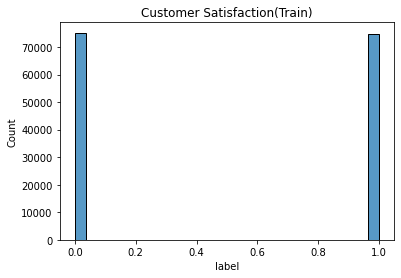

In [16]:
# 클래스 불균형 (class imbalance) 확인하기
import seaborn as sns

sns.histplot(train_data["label"]).set(title="Customer Satisfaction(Train)")

일단 훈련 데이터에서 클래스가 균형 잡힌 것으로 확인된다. 클래스가 매우 불균형하여 따로 두 레이블을 고르게 세팅할 필요가 없는 것이다.

다음으로 리뷰 데이터의 모든 단어를 볼 수 있는 WordCloud를 활용하여 시각화해보자.

In [ ]:
# 1. 필요한 모듈 불러오기
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
from matplotlib import rc
import pandas as pd 
# %matplotlib inline

In [ ]:
# 한글 폰트 준비
urllib.request.urlretrieve("http://macsplex.com/?module=file&act=procFileDownload&file_srl=2851&sid=ea4a36b12467c4446c21e70762c7d10f&module_srl=2822g", filename="AppleGothic.ttf")

('AppleGothic.ttf', <http.client.HTTPMessage at 0x7fd7174efa90>)

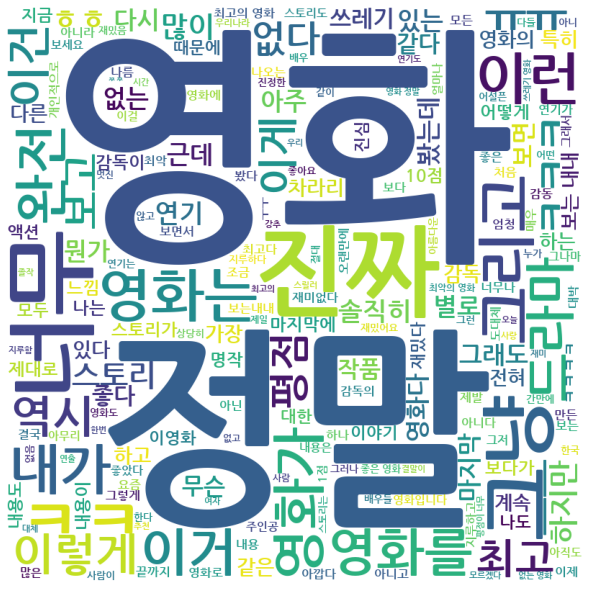

In [ ]:
# 2. Stopwords 및 특수문자 필터링을 위한 준비

comment_words = ''
stopwords = set(STOPWORDS)

tokenized_text = []

# 3. 문장 데이터를 단어화하기
for val in train_data["document"]:

  # 문장을 string으로 만들기
  val = str(val)

  # 문장을 쪼개기
  tokens = val.split()

  tokenized_text.append(tokens)
  comment_words += " ".join(tokens) + " "

wordcloud = WordCloud(width = 800, height = 800, 
                font_path='AppleGothic.ttf',
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

위 WordCloud를 보니 "정말", "영화", "진짜" 등의 단어가 가장 많이 나온 것을 알수있다. 하지만 엄밀히 따지자면, 이 단어들은 직접적으로 한 사람의 감정을 나타내기 보다는 특정한 대상이나, 그 대상을 확대하여 표현하기 위한 부사들이다. 이 단어들은 직접적으로 감정을 분석하는데 있어 도움이 되지 않기 때문에 이러한 단어들은 Stopwords로써 필터링할 수 있다.

In [ ]:
# 필터링할 추가적인 stopwords들 정의

stopwords_2 = ["영화", "진짜", "정말", "이거", "그냥", "너무", "영화가", "영화는",
             "이거", "이게", "이건", "영화의", "어떤", "아주", "계속", "영화다", 
             "영화를", "그리고"
]

##2.2 토큰화 및 Stopwords(불용어) 제거

WordCloud를 통해 본 것처럼, 모든 문장을 단어로 토큰화하고, 이전에 새롭게 정의한 불용어를 제거한다.

In [ ]:
# 토큰화된 문장확인
tokenized_text[0]

['아', '더빙..', '진짜', '짜증나네요', '목소리']

In [ ]:
len(tokenized_text)

150000

In [ ]:
# 새로운 불용어와 기존 불용어 필터링하기

def filter_stopwords(tokenized_text, stopwords_2):
  tokenized_filtered = []

  for i in tokenized_text:
    for word in i:
      if word not in stopwords and word not in stopwords_2:
        tokenized_filtered.append(word)
        
  return tokenized_filtered

In [ ]:
tokenized_filtered = filter_stopwords(tokenized_text, stopwords_2)

In [ ]:
# 필터링 되었는지 확인
tokenized_filtered[0:10]

['아',
 '더빙..',
 '짜증나네요',
 '목소리',
 '흠...포스터보고',
 '초딩영화줄....오버연기조차',
 '가볍지',
 '않구나',
 '너무재밓었다그래서보는것을추천한다',
 '교도소']

In [ ]:
len(tokenized_filtered)

1083270

In [ ]:
# 각 단어가 얼마나 나왔는지 카운트해보기

import operator

def word_count(tokenized_data):
  word_counter = {}

  for i in tokenized_data:
    if i in word_counter.keys():
      word_counter[i] += 1
    else:
      word_counter[i] = 1

  # 많이 나온 순서대로 정렬

  sorted_dict = dict( sorted(word_counter.items(),
                           key=operator.itemgetter(1), reverse=True))
  
  return sorted_dict

In [ ]:
tokenized_dict = word_count(tokenized_filtered)

In [ ]:
# 가장 상위 20개의 단어 보기
def top_20(tokenized_dict):
  top_20_words = list(tokenized_dict.items())[:20]
  return top_20_words

top_20(tokenized_dict)

[('이', 5059),
 ('영화.', 3598),
 ('왜', 3285),
 ('더', 3260),
 ('이런', 3249),
 ('수', 2945),
 ('잘', 2644),
 ('다', 2615),
 ('보고', 2557),
 ('좀', 2449),
 ('그', 2421),
 ('본', 2298),
 ('최고의', 2219),
 ('ㅋㅋ', 2019),
 ('내가', 2000),
 ('없는', 1957),
 ('이렇게', 1828),
 ('완전', 1780),
 ('평점', 1760),
 ('봤는데', 1746)]

크게 의미가 없는 단어들이 아직도 남아있다. 조금 더 불용어들을 필터링해보자.

In [ ]:
stopwords_2.extend(["이", "이렇게", "더", "수", "다", "그", "내가", "이렇게", 
               "완전", "봤는데", "영화.", "평점", "평점이", "왜", "이런", "본",
               "보고", "잘"
])

In [ ]:
tokenized_filtered = filter_stopwords(tokenized_text, stopwords_2)

len(tokenized_filtered)

1038630

In [ ]:
tokenized_dict = word_count(tokenized_filtered)

In [ ]:
# 가장 상위 20개의 단어 보기
top_20(tokenized_dict)

[('좀', 2449),
 ('최고의', 2219),
 ('ㅋㅋ', 2019),
 ('없는', 1957),
 ('있는', 1739),
 ('좋은', 1726),
 ('보는', 1600),
 ('내', 1595),
 ('다시', 1583),
 ('참', 1508),
 ('많이', 1478),
 ('역시', 1466),
 ('난', 1405),
 ('연기', 1365),
 ('재밌게', 1343),
 ('한', 1323),
 ('쓰레기', 1295),
 ('것', 1277),
 ('하는', 1236),
 ('또', 1231)]

드디어 감정을 나타내는 단어들이 좀 보이기 시작했다. "좀"이라는 말은, 어떻게 보면 직접적인 감정을 드러낸다고 할 수는 없지만, 일반적으로 "좀 그렇다.", "좀 별로다." 라는 식으로 부정적인 뉘앙스로 많이 쓰인다. "좀 좋다.", "좀 괜찮다."라는 말을쓰기도 하지만, 일상에서 자연스럽다고 느낄정도로 긍정적인 어투로 쓰이지는 않는 편이다. 그만큼 이 단어는 어느 정도 부정적인 감정을 나타낼 가능성이 높다. 하지만, "최고의"라는 굉장히 긍정적인 감정을 나타내는 단어가 뒤따른 것으로보아, 자신이 본 컨텐츠를 부정적으로 생각한 사람들 못지 않게, 긍정적으로 본 사람들도 상당히 많다는 것을 보여준다. 뒤 따르는 "ㅋㅋ"라는 웃음의 의성어는, 주로 무언가가 재미있거나 흥미로울 때 많이 쓴다. 이러한 용어의 빈도가 높았다는 사실 역시, 자신이 시청한 콘텐츠를 즐겁게 평가한사람이 많았다는 것을 보여준다. 그 이후에 나오는 "좋은", "재밌게"라는 단어들이 뒤따랐고, 상당히 부정적인 감정을 드러내는 "쓰레기"라는 표현도 상당한 빈도로 나온 것을 알 수 있다. 전체적으로 자신이 본 콘텐츠를 긍정적으로 본 사람들 못지않게, 부정적으로 평가한 사람들도 상당히 많았음을 알 수 있다. 

여기서 좀 더 전처리를 해본다. 이번에는 직접적으로 감정이 드러나는 단어를 찾기 위해 직접 감정이 드러나는 레벨까지 가본다. 그 후에, 몇가지 단어들을 특정한 감정으로 대체하여 보도록 하겠다.

In [ ]:
stopwords_2.extend(["보는", "내", "다시", "난", "연기", "한", "것", "하는", "또",
                    "역시", "좀", "참", "많이", "없는", "있는"
])

In [ ]:
tokenized_filtered = filter_stopwords(tokenized_text, stopwords_2)

len(tokenized_filtered)

1015418

In [ ]:
tokenized_dict = word_count(tokenized_filtered)

In [ ]:
top_20(tokenized_dict)

[('최고의', 2219),
 ('ㅋㅋ', 2019),
 ('좋은', 1726),
 ('재밌게', 1343),
 ('쓰레기', 1295),
 ('아', 1204),
 ('드라마', 1186),
 ('꼭', 1181),
 ('가장', 1178),
 ('보면', 1176),
 ('ㅋㅋㅋ', 1108),
 ('마지막', 1070),
 ('스토리', 1020),
 ('무슨', 999),
 ('ㅋ', 989),
 ('없고', 981),
 ('.', 981),
 ('볼', 959),
 ('ㅠㅠ', 958),
 ('같은', 956)]

## 2.3 키워드 분석하기

이쯤에서 감정이 드러난 단어들을 하나의 그룹으로 묶어보자. 즉, 키워드만을 추려서 특정한 감정을 나타내는 그룹으로 묶어본다. 여기서 주의할 것은 "ㅋㅋㅋ", "ㅋㅋ", "ㅋ"의 의미가 서로 다를 수 있다는 것이다. 참조: [ㅋㅋ - 위키백과, 우리 모두의 백과사전](https://ko.wikipedia.org/wiki/%E3%85%8B%E3%85%8B#:~:text=%E3%85%8B%E3%85%8B%EC%9D%80%20%EB%8C%80%ED%95%9C%EB%AF%BC%EA%B5%AD%EC%9D%98%20%EC%9D%B8%ED%84%B0%EB%84%B7,%EB%8A%90%EB%82%8C%EC%9D%84%20%EC%A4%84%20%EC%88%98%20%EC%9E%88%EB%8B%A4.)

In [ ]:
# 감정이 드러난 단어들을 묶어보기

emotion_dict = {"최고의": "극찬", "ㅋㅋ": "웃음", "좋은": "기쁨", "재밌게": "흥미",
                "쓰레기": "혐오", "ㅋㅋㅋ": "웃음", "ㅋ": "무심", "ㅠㅠ": "슬픔"
}

In [ ]:
from collections import defaultdict, OrderedDict

emotions_dict = defaultdict(int)

emotions_list = []

for k, v in tokenized_dict.items():
  for key, value in emotion_dict.items():
    if k == key:
      emotions_list.append((value, v))

for k, v in emotions_list:
  if k in emotions_dict:
    emotions_dict[k] += v
  else:
    emotions_dict[k] = v

emotions_dict = OrderedDict(sorted(emotions_dict.items(),
                            key=lambda item: item[1],
                            reverse=True))

emotions_dict

OrderedDict([('웃음', 3127),
             ('극찬', 2219),
             ('기쁨', 1726),
             ('흥미', 1343),
             ('혐오', 1295),
             ('무심', 989),
             ('슬픔', 958)])

In [ ]:
# Plotly로 시각화

# Pie Chart
import plotly.express as px

emotions = pd.Series(emotions_dict)

fig = px.pie(emotions, values=emotions, names=emotions.index, title="가장 두드러지게 나타난 감정", hover_data=[emotions], labels=emotions.index)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexes/base.py:4114: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



In [ ]:
# Bar chart
fig = px.bar(emotions, x=emotions.index, y=emotions, title="가장 두드러지게 나타난 감정")
fig.show()

가장 많이 나온 키워드들을 바탕으로 정리해본 결과, "ㅋㅋㅋ", "ㅋㅋ" 등의 의성어로 대표되는 웃음의 감정이 가장 두드러지게 드러났다. 일상 생활에서도 이러한 용어는 무언가 재치있거나 재미있는 것을 발견했을 때 자주 사용이 된다는 것을 감안하면, 아마 재미위주의 B급 감성 코미디 컨텐츠가 이러한 반응을 주로 이끌어내었을 것이다. 

또한 "최고의"라는 용어는 "극찬"의 표현으로써, 어떠한 분야에서 가장 두드러지거나 굉장한 평가를 이끌어냈을 때 쓰는 말이다. 요즘에는 "최고의 액션 영화", "최고의 판타지 영화", "올해 최고의 영화" 등 무언가 특정한 장르에서 상당히 좋게 평가되는 장르의 영화들을 이런식으로 많이 지칭한다. 그렇다는 것은, 아무래도 사람들의 입소문을 타고 유명해진 영화들이나, 일반 사람들도 워낙 유명해 많이 들어본 영화들이 아무래도 이러한 평가를 받았을 수 있다. 예를 들어, <미션 임파서블> 시리즈 같은 액션 영화, <반지의 제왕> 같은 판타지 영화, 거장 크리스토퍼 놀란 감독의 대작 <인터스텔라>나, 또는 최근에 아카데미에서 극찬을 받은 우리나라 영화 <기생충>등, 특정 장르를 대표하거나 감독의 색깔이 두드러지게 드러나는 영화들이 있을 수 있다. 

또한 다음 감정으로 "기쁨"과 "흥미"가 두드러지게 나왔는데, 아무래도 관객으로 하여금 흥미진진한 스토리나 반전 등의 영화로 무장하거나, 권선징악의 다소 진부한 형태를 따르더라도 흥미로운 스토리로 전개되는 영화들에 이런 반응을 보일 수 있다. 엄청나게 큰 제작비로 만들어진 것은 아니지만, 탄탄한 스토리로 어필하는 부류의 영화들, 예를 들어, 이전에 언급한 <기생충>, 지금까지도 많이 회자되는 <노인을 위한 나라는 없다>, 또는 스티븐 스필버그 감독의 역작 < A.I > 같은 영화를 예로 들 수 있다.

또한 이전에 "좋은"이라는 키워드도 많이 나왔다는 것을 확인했다. 일반적으로 "좋은 영화"라고 이야기 할때 대부분 단순히 재미를 떠나 관객으로 하여금 어떠한 메시지를 주는 영화들이 있을 수 있다. 내가 최근에 본 < 굿윌헌팅(Good Will Hunting)>, <트루먼 쇼(Truman Show)>, <델마와 루이스(Thelma and Louise)>같은, 흥미로운 스토리를 가지면서도 어떠한 메시지가 담긴 영화들이 될 수 있다.  

"혐오"와 "무심"같은 부정적인 감정은 전체에서 약 20%가까이 나왔는데, 그만큼 자신들이 본 콘텐츠에 대해 거부감을 갖거나 만족하지 못한 사람도 많았다는 것을 알려준다. 영화 리뷰를 평소 관심있게 보다보면, 개봉전 부터 큰 기대를 안고 보았으나, 영화가 생각만큼 재미가 없었을 때 이런 반응이 자주 나오곤 한다. 주로 많은 기대를 받고 상당한 비용을 들여 재작했으나, 그 기대에 한참 미치지 못한 블록버스터 급의 영화들에서 이런 반응이 많이 나올 수 있다. 예를 들어 실사화된 <드래곤 볼>, DC코믹스의 히어로들의 세계관을 보여준 <저스티스 리그>, 우리나라에서도 많은 악평을 낳은 영화 < 7광구 > 등이 대표적으로 이러한 반응을 이끌어 냈을 영화들이었을 수 있다. 즉, 소위 마케팅만 잘 된 속빈 강정같은 작품을 본 후에 이런 감정들이 생기기 쉽다. 이러한 감정들은 아무래도 왓챠의 비즈니스에 있어서 부정적인 감정들이고, 20%의 숫자는 적지 않기 때문에, 이러한 반응을 이끌어 낼만한 완성도가 떨어지는 영화들에 대해서는 판권 계약의 우선 순위에서 조금 더 뒤로 미룰 필요가 있다. 

마지막으로 "슬픔"의 감정도 존재했는데, 정말 감동적이면서 눈물 샘을 자극하는 영화들이 이런 감정을 이끌어 냈을 수 있다. 재미있으면서도 감동적이기로 유명했던 영화 < 7번방의 선물 >, 한 아버지의 눈물겨운 성장스토리인 <행복을 찾아서>, 로맨틱의 끝판왕 <타이타닉>과 같은 영화들이 사람들의 눈물 샘을 많이 자극한 대표적인 영화라고 할 수 있다. 

지금까지 키워드로 언급된 감정들과, 각 감정을 이끌어낼 수 있는 영화들을 예로들었다. 예를 든 것처럼 왓챠에서도 만약 이러한 감정 키워드들과 관련이 깊은 영화들을 정리해서 추천한다면, 훨씬 더 이러한 감정들을 자극할 수 있을 것이다. 각 감정을 좀 더 느끼길 원하는 유저들의 만족도를 조금 더 끌어올리면서 유저들에게 좀 더 최적화된 컨텐츠를 제공할 수 있을 것이다. 




# 3. 모델링

## 3.1 모델링을 위한 준비

이제는 "대체로 왓챠의 고객들은 콘텐츠에 만족한다."라는 가설을 시험하기 위해 모델링을 준비해야한다. BERT모델에 맞게 인코딩 및 표준화 작업이 필요하다. 이 모델은 Transformer 모델을 기반으로 한다.

다음으로 이 모델을 사용하기 위해 PyTorch가 필요하다. 또한, Transformer 모듈에서 Bert를 사용하기 위한 메소드들을 불러와야한다.

In [ ]:
# Bert 사용에 필요한 모듈 불러오기
import torch

from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, Adafactor, BertConfig
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import random
import time
import datetime

Bert를 위해 조금 더 파워풀한 GPU를 사용해야한다. GPU가 사용되는지 확인한다.

In [ ]:
import os

n_devices = torch.cuda.device_count()
print(n_devices)

for i in range(n_devices):
    print(torch.cuda.get_device_name(i))

1
Tesla T4


BERT는 문장의 앞에 [CLS]를 붙이고, 끝에는 [SEP]을 붙여 처리를 해 주어야한다. 그러므로 반복문 등을 활용하여 처리해 주어야한다. 

In [ ]:
# BERT에 맞는 Tag 달아주기
bert_text = []

for i in train_data['document']:
  bert = ["[CLS] " + str(i) + " [SEP]"]
  bert_text.append(bert)

bert_text[:5]

[['[CLS] 아 더빙.. 진짜 짜증나네요 목소리 [SEP]'],
 ['[CLS] 흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나 [SEP]'],
 ['[CLS] 너무재밓었다그래서보는것을추천한다 [SEP]'],
 ['[CLS] 교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정 [SEP]'],
 ['[CLS] 사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다 [SEP]']]

In [ ]:
test_text = []

for i in test_data['document']:
  bert = ["[CLS] " + str(i) + " [SEP]"]
  test_text.append(bert)

test_text[:5]

[['[CLS] 굳 ㅋ [SEP]'],
 ['[CLS] GDNTOPCLASSINTHECLUB [SEP]'],
 ['[CLS] 뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아 [SEP]'],
 ['[CLS] 지루하지는 않은데 완전 막장임... 돈주고 보기에는.... [SEP]'],
 ['[CLS] 3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠?? [SEP]']]

이전 단계에서 이미 토큰화된 것을 사용하면 좋겠지만, 위와 같이 CLS 및 SEP 태그를 달아주어야 했기 때문에, 최초의 데이터를 활용했다. 이번에는 Bert multilingual 모델에 있는 tokenizer를 활용하여 토큰화한다.

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)
tokenized_data = []
for i in bert_text:
  for j in i:
    tokens = tokenizer.tokenize(j)
    tokenized_data.append(tokens)

print(tokenized_data[0:10])


[['[CLS]', '아', '더', '##빙', '.', '.', '진', '##짜', '짜', '##증', '##나', '##네', '##요', '목', '##소', '##리', '[SEP]'], ['[CLS]', '[UNK]', '.', '.', '.', '포', '##스터', '##보', '##고', '초', '##딩', '##영', '##화', '##줄', '.', '.', '.', '.', '오', '##버', '##연', '##기', '##조', '##차', '가', '##볍', '##지', '않', '##구', '##나', '[SEP]'], ['[CLS]', '[UNK]', '[SEP]'], ['[CLS]', '교', '##도', '##소', '이야기', '##구', '##먼', '.', '.', '솔', '##직', '##히', '재', '##미', '##는', '없다', '.', '.', '평', '##점', '조', '##정', '[SEP]'], ['[CLS]', '사', '##이', '##몬', '##페', '##그', '##의', '익', '##살', '##스', '##런', '연', '##기가', '돋', '##보', '##였던', '영화', '!', '스', '##파', '##이', '##더', '##맨', '##에서', '늙', '##어', '##보', '##이', '##기', '##만', '했', '##던', '커', '##스', '##틴', '던', '##스트', '##가', '너', '##무', '##나', '##도', '이', '##뻐', '##보', '##였다', '[SEP]'], ['[CLS]', '막', '걸', '##음', '##마', '[UNK]', '3', '##세', '##부터', '초', '##등학교', '1', '##학', '##년', '##생', '##인', '8', '##살', '##용', '##영', '##화', '.', '[UNK]', '.', '.', '.', '별', '##반', '##개', '#

In [ ]:
tokenized_test_data = []
for i in test_text:
  for j in i:
    tokens = tokenizer.tokenize(j)
    tokenized_test_data.append(tokens)

print(tokenized_test_data[0:5])

[['[CLS]', '굳', '[UNK]', '[SEP]'], ['[CLS]', 'G', '##D', '##NT', '##OP', '##CL', '##AS', '##SI', '##NT', '##H', '##EC', '##L', '##UB', '[SEP]'], ['[CLS]', '뭐', '##야', '이', '평', '##점', '##들은', '.', '.', '.', '.', '나', '##쁘', '##진', '않', '##지만', '10', '##점', '짜', '##리는', '더', '##더', '##욱', '[UNK]', '[SEP]'], ['[CLS]', '지', '##루', '##하지', '##는', '않은', '##데', '완', '##전', '막', '##장', '##임', '.', '.', '.', '돈', '##주', '##고', '보', '##기에', '##는', '.', '.', '.', '.', '[SEP]'], ['[CLS]', '3D', '##만', '아', '##니', '##었', '##어', '##도', '별', '다', '##섯', '개', '줬', '##을', '##텐', '##데', '.', '.', '왜', '3D', '##로', '나', '##와', '##서', '제', '심', '##기를', '불', '##편', '##하게', '하', '##죠', '?', '?', '[SEP]']]


이전 딥러닝 수업에서 padding이 매우 중요하다고 배웠다. 가장자리에 있는 데이터들이 1번만 사용되는 것을 막기 위해 기존 데이터에 0의 테두리를 두르는 것이다. 이 작업이 BERT 모델을 돌리기 위해서도 필요하다. 

In [ ]:
# padding
input_ids = []
for i in tokenized_data:
  ids = tokenizer.convert_tokens_to_ids(i)
  input_ids.append(ids)

print(input_ids[0])

[101, 9519, 9074, 119005, 119, 119, 9708, 119235, 9715, 119230, 16439, 77884, 48549, 9284, 22333, 12692, 102]


In [ ]:
input_ids_test = []
for i in tokenized_test_data:
  ids = tokenizer.convert_tokens_to_ids(i)
  input_ids_test.append(ids)

print(input_ids_test[0])

[101, 8911, 100, 102]


In [ ]:
max_len = 128
input_ids = pad_sequences(input_ids, maxlen=max_len, dtype='long', truncating='post', padding='post')
input_ids[0]

array([   101,   9519,   9074, 119005,    119,    119,   9708, 119235,
         9715, 119230,  16439,  77884,  48549,   9284,  22333,  12692,
          102,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
      

In [ ]:
input_ids_test = pad_sequences(input_ids_test, maxlen=max_len, dtype='long', truncating='post', padding='post')
input_ids_test[0]

array([ 101, 8911,  100,  102,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0])

다음으로 Masking을 준비한다. 

In [ ]:
attention_masks = []

for ids in input_ids:
  ids_mask = []
  for id in ids:
      masked = float(id>0)
      ids_mask.append(masked)
  attention_masks.append(ids_mask)
    
print(attention_masks[0])
print(len(attention_masks[0]))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
128


In [ ]:
attention_masks_test = []

for ids in input_ids_test:
  ids_mask = []
  for id in ids:
      masked = float(id>0)
      ids_mask.append(masked)
  attention_masks_test.append(ids_mask)
    
print(attention_masks_test[0])
print(len(attention_masks_test[0]))

[1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
128


모델링을 위해서는 train 데이터와 validation 데이터를 분리해야한다. 테스트 데이터는 이미 분리되어있다. 다만 이후 모델의 fine-tuning을 위한 데이터와, 이후 모델링을 위해 tensor로 변환할 데이터를 분리해 주어야한다.

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    input_ids, train_data['label'].values, random_state=42, test_size=0.2)

train_masks, validation_masks, _, _ = train_test_split(attention_masks, 
                                                       input_ids,
                                                       random_state=42, 
                                                       test_size=0.2)

In [ ]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((120000, 128), (30000, 128), (120000,), (30000,))

In [ ]:
# Fine-tuning과 Tensor로 사용할 데이터를 분리
X_train_tune = X_train
y_train_tune = y_train
X_val_tune = X_val
y_val_tune = y_val

In [ ]:
X_test_tensor = input_ids_test
y_test_tensor = test_data["label"].values
test_masks = attention_masks_test

다음으로 input_ids, 타깃 라벨, masking을 PyTorch로 변환해야한다.

In [ ]:
# PyTorch로 변환

X_train_tensor = torch.tensor(X_train)
y_train_tensor = torch.tensor(y_train)
train_masks = torch.tensor(train_masks)
X_val_tensor = torch.tensor(X_val)
y_val_tensor = torch.tensor(y_val)
validation_masks = torch.tensor(validation_masks)

In [ ]:
X_test_tensor = torch.tensor(X_test_tensor)
y_test_tensor = torch.tensor(y_test_tensor)
test_masks = torch.tensor(attention_masks_test)

이번에는 배치 사이즈를 지정한다. 주로 큰 사이즈를 설정해보고, VRAM 에러 메시지가 난다면, 더 작은 사이즈로 줄여나간다. 8의 배수로 설정하는 것이 일반적이다. 

In [ ]:
batch_size = 32

train = TensorDataset(X_train_tensor, train_masks, y_train_tensor)
train_sampler = RandomSampler(train)

val = TensorDataset(X_val_tensor, validation_masks, y_val_tensor)
val_sampler = SequentialSampler(val)


test = TensorDataset(X_test_tensor, test_masks, y_test_tensor)
test_sampler = RandomSampler(test)

train_dataloader = DataLoader(train, sampler=train_sampler, batch_size=batch_size)
val_dataloader = DataLoader(val, sampler=val_sampler, batch_size=batch_size)
test_dataloader = DataLoader(test, sampler=test_sampler, batch_size=batch_size)

다음으로 GPU가 사용가능한지를 체크해야한다. GPU를 사용할 수 있게 설정해준다. PyTorch는 GPU를 돌릴 수 있는 CUDA 라이브러리를 지원하는데, PyTorch를 통해 CUDA를 사용할 수 있는 디바이스를 초기화한다. 

In [ ]:
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


##3.2 모델 Fine-Tuning

BERT모델은 Fine-Tuning을 통해 원하는 목적에 맞게 최적화 시킬 수도 있다. 이번 단계에서는 모델의 최종 학습 전, 모델을 Fine-Tuning하여 성능을 올리고자 한다.

일단 BERT 모델을 초기화한다. Transformers의 BertForSequenceClassification 모듈을 활용한다. 타깃은 0과 1로 이루어져 있기 때문에, 라벨의 수는 2가 될 것이다. 사용할 BERT모듈의 이름은 "bert-case-multilingual-cased"라는 것으로 영어 이외의 언어 텍스트 데이터를 처리하는데 유용하다.

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=2)
model.cuda()

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

다음으로 필요한 파라미터만 Fine-Tuning을 진행할 수 있도록 requires_grad를 False로 설정한다. 

In [ ]:
for param in model.base_model.parameters():
    param.requires_grad = False

Fine Tuning을 위해서는 Transformer모듈이 제공하는 Trainer 및 TrainingArguments라는 메소드를 사용해야하는데, 이를 위해서는 이 메소드에 입맞에 맞는 형태로 데이터를 넣어주어야한다. 이전에 활용한 train_test_split를 이용해, 데이터를 두 메소드가 원하는 형태로 다시 분리한다. 주의할 것은, 이 메소드들은 리스트의 형태로만 데이터를 받아들이고, 데이터 자체는 모두 string이어야한다는 것이다. 라벨은 궁극적으로 예측할 타깃이기 때문에 string으로 변환시키지 않는다. 이전에 토큰화 단계에서 나눈 데이터들은 추후 실제 학습에 활용할 것이다.

In [ ]:
from sklearn.model_selection import train_test_split
train_queries, val_queries, train_docs, val_docs, train_labels, val_labels = train_test_split(
    train_data["id"].apply(str).tolist(), 
    train_data["document"].apply(str).tolist(), 
    train_data["label"].tolist(), 
    test_size=.2
)

다음으로 나눈데이터를 토큰화해야한다. 이 과정에서 BertTokenizerFast라는 transformers 모듈의 객체를 활용할 수 있다. 

In [ ]:
from transformers import BertTokenizerFast

model_name = "bert-base-multilingual-cased"
tokenizer = BertTokenizerFast.from_pretrained(model_name)

train_encodings = tokenizer(train_queries, train_docs, truncation=True, padding='max_length', max_length=max_len)
val_encodings = tokenizer(val_queries, val_docs, truncation=True, padding='max_length', max_length=max_len)

마지막으로 Fine-Tuning을 실시하기 전, 토큰화한 데이터 셋을 인코딩한다.

In [ ]:
import torch

class Cord19Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = Cord19Dataset(train_encodings, train_labels)
val_dataset = Cord19Dataset(val_encodings, val_labels)


마지막으로 Fine-Tuning을 실시하여, 모델의 학습을 진행하기전에 최적화 시킨다. TrainingArguments 매소드의 경우, 나중에 원한다면 Fine-Tuned된 모델을 사용할 수 있도록 모델을 지정된 경로에 저장할 수 있는 옵션을 제공한다. Epoch가 너무 크면 학습이 너무 오래걸리므로 3으로 가져간다. Batch Size는 학습데이터와 검증 데이터 모두 32로 세팅해본다. Warm-up step과 weight decay값은 0으로 지정하고, checkpoint는 1개만 가져간다. 

In [ ]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    evaluation_strategy="epoch",     # Evaluation is done at the end of each epoch.
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=32,  # batch size per device during training
    per_device_eval_batch_size=32,   # batch size for evaluation
    warmup_steps=0,                # number of warmup steps for learning rate scheduler
    weight_decay=0,               # strength of weight decay
    save_total_limit=1,              # limit the total amount of checkpoints. Deletes the older checkpoints.    
)


trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset             # evaluation dataset
)

trainer.train()

Epoch,Training Loss,Validation Loss
1,0.688607,0.686903
2,0.685094,0.684274
3,0.684875,0.683608


TrainOutput(global_step=11250, training_loss=0.6872126274956597)

##3.3 모델 학습

모델의 학습을 위해 가장먼저 Optimizer를 지정하고 epochs값을 지정해주어야한다. 여기서는 AdamW와 Adafactor 옵티마이저를 사용하며, 학습률(learning rate)은 1e-5로, 업데이트되며 0으로 나뉘어지는 것을 방지하기 위한 epsilon값은 1e-8로 설정한다. epoch은 3으로 설정했다. Weight Decay값은 이전 tuning 때와 같이 0, num_warmup_steps역시 0으로 설정했다.

In [ ]:
# 옵티마이저 설정
optimizer = AdamW(model.parameters(),
                  lr = 1e-5, # 학습률
                  eps = 1e-8 # 0으로 나누는 것을 방지하기 위한 epsilon 값,
                )
# 에폭수
epochs = 3

# 총 훈련 스텝
total_steps = len(train_dataloader) * epochs

# Learning rate decay를 위한 스케줄러
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)
        

모델링을 위한 마지막 설정은 정확도를 측정할 수 있는 함수를 만들어 주고, 학습에 소요된 시간을 나타내는 함수를 정의해 주는 것이다. 모델의 성능 측정을 위해 둘다 필수적인 요소들이기 때문이다.

In [ ]:
# 정확도 계산 함수
def accuracy_measure(y_pred, y):
    pred_flattened = np.argmax(y_pred, axis=1).flatten()
    y_flattened = y.flatten()
    return np.sum(pred_flattened == y_flattened) / len(y_flattened)

# 시간 표시 함수
def time_elapsed(elapsed):
    # 반올림
    elapsed = int(round((elapsed)))
    # hh:mm:ss으로 형태 변경
    return str(datetime.timedelta(seconds=elapsed))

이제 학습을 할 수 있는 준비를 마쳤다. 학습 전에 Random seed를 고정해야한다. 일반적으로 Random State는 42로 설정하고 시작하기 때문에 여기서도 Seed값은 42로 설정한다. Gradient도 초기화 하여 Optimizer가 Gradient Descent를 진행할 때 도움이 되도록 한다. 

In [ ]:
# 재현을 위해 랜덤시드 고정
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# 그래디언트 초기화
model.zero_grad()

본격적으로 학습을 시작한다. 전체적인 단계는 훈련과 검증 두 부분으로 나뉘어진다. 

훈련 단계에서는 정해진 에폭수 만큼 학습을 반복한다. 시간을 초기화하고, 비용함수를 게산해야하기 때문에 이 역시 초기화한다. 이전에 설정한 batch_size 만큼, 설정한 데이터로더에서 나누어서 사용한다. 시간이 얼마나 경과 했는지는 이전에 설정한 함수를 활용한다. 배치를 GPU에 입력하면 GPU는 입력된 배치를 처리하기 시작한다. 여기서 Forward Propagation으로 비용함수를 계산하고, Backward Propagation로 Gradient Descent를 수행하며 학습을 하게된다. 이전에 설정한 스케줄러로 learning rate decay를 실시하고, 설정한 batch_size 만큼 데이터를 사용하면, gradient를 다시 초기화하여, 다음 batch_size만큼의 데이터를 사져온다. 이 작업을 반복하면서 모든 데이터를 사용하게 되면, 평균 에러와 평균 학습 시간을 게산한다. Fine-Tuning전 분리한 데이터인 train_dataloader, val_dataloader, test_dataloader를 사용한다.

훈련이 끝나면 검증을 실행하는데, 전반적인 과정은 훈련단게와 비슷하다. 다만, 마지막에 GPU의 예측 결과를 CPU로 가져와, 실제 라벨과 비교하여 정확도를 계산하게된다. 최종 출력 정확도와 소요시간을 계산하며 모든 과정을 마무리한다. 

In [ ]:
# 본격적인 학습
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    
    # 현재 훈련 조건 표시
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # 시작 시간 설정
    t0 = time.time()

    # 로스 초기화
    total_loss = 0

    # 훈련모드로 변경
    model.train()
        
    # 데이터로더에서 배치만큼 반복하여 가져옴
    for step, batch in enumerate(train_dataloader):
        # 경과 정보 표시
        if step % 500 == 0 and not step == 0:
          elapsed = time_elapsed(time.time() - t0)
          print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)
            
        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch

        # Forward 수행                
        outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask, 
                            labels=b_labels)
            
        # 로스 구함
        loss = outputs[0]

        # 총 로스 계산
        total_loss += loss.item()

        # Backward 수행으로 그래디언트 계산
        loss.backward()

        # 그래디언트 클리핑
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # 그래디언트를 통해 가중치 파라미터 업데이트
        optimizer.step()

        # 스케줄러로 학습률 감소
        scheduler.step()

        # 그래디언트 초기화
        model.zero_grad()

    # 평균 로스 계산
    avg_train_loss = total_loss / len(train_dataloader)            

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(time_elapsed(time.time() - t0)))        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    #시작 시간 설정
    t0 = time.time()

    # 평가모드로 변경
    model.eval()

    # 변수 초기화
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # 데이터로더에서 배치만큼 반복하여 가져옴
    for batch in val_dataloader:
        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)
            
        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch
            
        # 그래디언트 계산 안함
        with torch.no_grad():     
          # Forward 수행
          outputs = model(b_input_ids, 
                                token_type_ids=None, 
                                attention_mask=b_input_mask)
            
          # 로스 구함
          logits = outputs[0]

          # CPU로 데이터 이동
          logits = logits.detach().cpu().numpy()
          label_ids = b_labels.to('cpu').numpy()
            
          # 출력 로짓과 라벨을 비교하여 정확도 계산
          tmp_eval_accuracy = accuracy_measure(logits, label_ids)
          eval_accuracy += tmp_eval_accuracy
          nb_eval_steps += 1

    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(time_elapsed(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 3 ========
Training...
  Batch   500  of  3,750.    Elapsed: 0:02:04.
  Batch 1,000  of  3,750.    Elapsed: 0:04:05.
  Batch 1,500  of  3,750.    Elapsed: 0:06:07.
  Batch 2,000  of  3,750.    Elapsed: 0:08:09.
  Batch 2,500  of  3,750.    Elapsed: 0:10:11.
  Batch 3,000  of  3,750.    Elapsed: 0:12:13.
  Batch 3,500  of  3,750.    Elapsed: 0:14:14.

  Average training loss: 0.67
  Training epcoh took: 0:15:15

Running Validation...
  Accuracy: 0.63
  Validation took: 0:03:47

======== Epoch 2 / 3 ========
Training...
  Batch   500  of  3,750.    Elapsed: 0:02:02.
  Batch 1,000  of  3,750.    Elapsed: 0:04:03.
  Batch 1,500  of  3,750.    Elapsed: 0:06:05.
  Batch 2,000  of  3,750.    Elapsed: 0:08:07.
  Batch 2,500  of  3,750.    Elapsed: 0:10:08.
  Batch 3,000  of  3,750.    Elapsed: 0:12:10.
  Batch 3,500  of  3,750.    Elapsed: 0:14:11.

  Average training loss: 0.67
  Training epcoh took: 0:15:12

Running Validation...
  Accuracy: 0.64
  Validation took: 0:03:4

In [ ]:
#시작 시간 설정
t0 = time.time()

# 평가모드로 변경
model.eval()

# 변수 초기화
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# 데이터로더에서 배치만큼 반복하여 가져옴
for step, batch in enumerate(test_dataloader):
    # 경과 정보 표시
    if step % 100 == 0 and not step == 0:
        elapsed = time_elapsed(time.time() - t0)
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_dataloader), elapsed))

    # 배치를 GPU에 넣음
    batch = tuple(t.to(device) for t in batch)
    
    # 배치에서 데이터 추출
    b_input_ids, b_input_mask, b_labels = batch
    
    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)
    
    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    # 출력 로짓과 라벨을 비교하여 정확도 계산
    tmp_eval_accuracy = accuracy_measure(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

print("")
print("Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
print("Test took: {:}".format(time_elapsed(time.time() - t0)))

  Batch   100  of  1,563.    Elapsed: 0:00:24.
  Batch   200  of  1,563.    Elapsed: 0:00:49.
  Batch   300  of  1,563.    Elapsed: 0:01:14.
  Batch   400  of  1,563.    Elapsed: 0:01:38.
  Batch   500  of  1,563.    Elapsed: 0:02:02.
  Batch   600  of  1,563.    Elapsed: 0:02:26.
  Batch   700  of  1,563.    Elapsed: 0:02:51.
  Batch   800  of  1,563.    Elapsed: 0:03:15.
  Batch   900  of  1,563.    Elapsed: 0:03:39.
  Batch 1,000  of  1,563.    Elapsed: 0:04:03.
  Batch 1,100  of  1,563.    Elapsed: 0:04:28.
  Batch 1,200  of  1,563.    Elapsed: 0:04:52.
  Batch 1,300  of  1,563.    Elapsed: 0:05:16.
  Batch 1,400  of  1,563.    Elapsed: 0:05:40.
  Batch 1,500  of  1,563.    Elapsed: 0:06:05.

Accuracy: 0.64
Test took: 0:06:20


모델은 약 64%의 정확도로 타깃을 예측했다. 훈련 데이터 및 검증 데이터로 진행했을 때와 그렇게 크게 차이가 나지 않아, 과적합의 문제는 크지 않은 것으로 보인다. 그렇다면 실제 우리가 예측하려했던 타깃의 비율은 어느정도일까?

[Text(0.5, 1.0, 'Customer Satisfaction(Test)')]

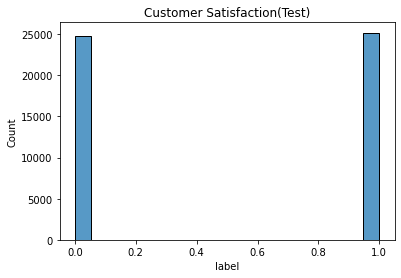

In [17]:
# 실제 테스트 데이터 클래스 균형 보기
sns.histplot(test_data["label"]).set(title="Customer Satisfaction(Test)")

우리가 실험하고자 하는 가설은 "왓챠의 콘텐츠에 만족하는 고객과 만족하지 못하는 고객의 수가 균등하다."라는 것이었다. 타깃 데이터의 실제 분포는 이 가설에 맞게 끔 설정되었고, 모델은 64% 정도의 정확도로 실제 타깃을 예측했다. 모델은 귀무가설이 이 정도의 확률로 유의하다고 예측한 것이다. 따라서, 귀무가설을 기각하지 않게 되었다. 만족하는 유저들 만큼, 만족하지 못하는 유저들이 있다는 것이 어느 정도 유의하다고 볼 수 있다는 의미다. 

# 4. 결론

## 4.1 해석

모델에 의하면, 결국 왓챠의 콘텐츠에 만족하지 못하는 사람들이 만족하는 사람들 만큼 많다는 것은 100% 사실은 아닐 수 있지만, 어느 정도 유의하다고 볼 수 있다. 이전 EDA에서 가장 두드러지게 나타난 감정 키워드들 중 부정적인 감정보다 긍정적인 것들이, 약 20대 80의 비율로 더 많이 드러났었다. 하지만, 실제로 한 꺼풀 더 벗겨보니, 불만족스러웠던 사람의 수가 리뷰의 거의 절반이었다는 것을 알 수 있었다. 나는 이 분석 결과를 왓챠의 마케팅 팀장에게 알려, 콘텐츠를 좀 더 효과적으로 관리해야 한다는 경각심을 줄 수 있다. 왓챠는 좀 더 흥미로운 콘텐츠를 마련하고, 유저들의 만족도를 올리기 위해 조금 더 맞춤형 콘텐츠 추천 서비스를 개선해야할 필요가 있을 것이다.

## 4.2 마치며

이번 딥러닝 모델링을 통해, 내가 평소 관심있던 분야인 자연어처리에 대해서 훨씬 더 흥미를 가지게되었다. 처음 리뷰 데이터의 텍스트를 처리하면서, WordCloud를 통해 전체적으로 어떤 단어들이 가장 많이 등장했는지 볼 수 있었고, 이를 바탕으로 불용어들을 처리하는 과정이 매우 재미있었다. 무엇보다도, 내가 가진 언어적 지식을 바탕으로, 특정 단어가 감정을 직접적으로 드러내는지, 그렇지 않은지를 구분해 낼 수 있었다는 것이 매우 보람있었다. 이를 바탕으로, 빈도 수가 높은 단어들 중 가장 감정이 두드러지게 나타난 단어를 찾을 수 있었고, 각 단어들에 가장 가까운 감정 키워드를 대체하여, 전체적으로 어떠한 감정들이 가장 두드러지게 나타났는지 알 수 있었다. 

내가 평소 영화나 책 리뷰를 많이 보았다는 것 또한 이번 프로젝트를 하는데 있어 큰 도움이 되었다. 덕분에 데이터를 보면서, 사람들이 주로 영화의 특성에 따라 다른 감정을 보이고, 보통 기대와 달리 시청한 영화가 실망스러웠을 때 미묘하거나 강하게 부정적인 단어를 많이 쓴다는 사실을 파악 할 수 있었다. 내가 영화를 좋아하고, 글읽기를 좋아한다는 것이 이번 자연어처리 프로젝트를 진행하는데 상당한 이점으로 작용했다. 다시한번 도메인 지식이 정말 중요하다는 것을 느꼈다.

무엇보다도, 그동안 숫하게 들어왔던 BERT라는 Transformer기반 모델을 사용할 수 있었던 것이 매우 기뻤다. 사실, 이 모델이 어떠한 원리로 작동하는지에 대해서는 아직 속속들이 파악하지 못했지만, 코딩으로 구현해내는 작업은 생각보다 그리 어렵지 않았다. BERT를 사용한 많은 예제들을 찾아보고, 내가 직접 내 프로젝트에 맞게 수정도 해 보면서, 이 모델을 사용하기 위해 어떠한 설정을 해 주어야하고, 어떤 준비를 해야하는지 알게 되었다는 것이 정말 큰 배움이었다. 가장 중요한 것은, 내가 사용하고자 하는 목적에 맞게 Fine-Tuning을 거쳐 모델을 최적화시키는 작업이 필요하다는 것을 배운 것이다. 앞으로 이 모델의 원리에 대해 좀 더 탐구하고, BERT이외에도 자연어 처리에서 널리 이용되는 GPT-3같은 다른 모델들에 대해서도 배워보고 싶다는 생각이들었다.

다만 아쉬웠던 것은, Topic Modelling까지 진행하지 못했다는 점이다. 사실, BERT 모델링을 완성하고나서 시간을 내 진행하려고 했지만, 생각보다 모델의 튜닝 작업이 시간이 많이 걸렸다. 모델링을 하는 것이 더 우선이었기에, 다음에 기회가 된다면 개인적으로 Topic Modelling도 해볼 수 있었으면 좋겠다는 생각을 해본다. 

마지막으로 "이 프로젝트가 굳이 딥러닝 모델을 필요로하는 것이 맞을까?"라는 점에 대해서는 아직 의문이 든다. 정확도가 약간 실망스럽게 나왔기 때문이다. 만약에 GPU의 용량이 좀 더 남아서, 또 시간이 좀 더 있었다면 머신 러닝 모델을 통해서 더 나은 정확도를 얻을 수 있는지 보고 싶다는 생각도들었다. 둘을 비교해 보았다면, 굳이 BERT를 쓰지 않고도 더 정확한 모델을 시험해 볼 수 있지 않았을까 하는 아쉬움이 들기 때문이다. 이 부분 역시 기회가 된다면 좀 더 탐구해 보고싶다. 결국, 가장 중요한 것은 기술 그 자체가 아니라, 문제를 해결하기 위한 가장 효율적인 수단을 찾는 것이기 때문이다. 






##4.3 참조

* [네이버 데이터](https://github.com/e9t/nsmc/)
* [BERT로 네이버 영화 리뷰데이터 분류하기](http://yonghee.io/bert_binary_classification_naver/)
* [Fine-tuning a BERT model with transformers](https://towardsdatascience.com/fine-tuning-a-bert-model-with-transformers-c8e49c4e008b)